# Income Predictor
**Goal: Create a model that can predict whether someone makes over 50k or below 50k**

Technique
- Feature Engineering
- Feature Selection
- Create neural network
- Evaluate model

In [1]:
import pandas as pd
import numpy as np
import sklearn
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from utils import *
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer
warnings.filterwarnings("ignore") 

In [2]:
# load data for training and testing
df_train = load_data('../data/au_train.csv')
df_test = load_data('../data/au_test.csv')

## Feature Engineering
- One hot encode all categorical features
- Limit native-country feature to U.S. and non-U.S. and one hot encode
- Binarize labels
- Standardize features

In [3]:
df_train['US'] = df_train['native-country'] == ' United-States'
df_train = df_train.drop(['native-country'], axis=1)

df_test['US'] = df_test['native-country'] == ' United-States'
df_test = df_test.drop(['native-country'], axis=1)

In [4]:
print(df_train.head())

   age          workclass  fnlwgt   education  education-num  \
0   39          State-gov   77516   Bachelors             13   
1   50   Self-emp-not-inc   83311   Bachelors             13   
2   38            Private  215646     HS-grad              9   
3   53            Private  234721        11th              7   
4   28            Private  338409   Bachelors             13   

        marital-status          occupation    relationship    race      sex  \
0        Never-married        Adm-clerical   Not-in-family   White     Male   
1   Married-civ-spouse     Exec-managerial         Husband   White     Male   
2             Divorced   Handlers-cleaners   Not-in-family   White     Male   
3   Married-civ-spouse   Handlers-cleaners         Husband   Black     Male   
4   Married-civ-spouse      Prof-specialty            Wife   Black   Female   

   capital-gain  capital-loss  hours-per-week   class     US  
0          2174             0              40   <=50K   True  
1             

In [5]:
def one_hot_encode(df, columns):
    '''
    Handles categorical inputs by creating a binary feature for each possible category,
    assigning a value of 1 for the feature that corresponds to the original category and 0
    for the remaining
    '''
    return pd.get_dummies(df, columns=columns)

In [6]:
def binarize_lbls(labels):
    '''
    Binarizes dependent variables (0 and 1)
    '''
    lb = LabelBinarizer()
    return pd.DataFrame(lb.fit_transform(labels), columns=['class'])

In [7]:
# converting categorical values to numerical values
categorical_columns = ['workclass', 'education', 'marital-status',\
                       'relationship', 'race', 'sex', 'US', 'occupation']
df_train_encoded = one_hot_encode(df_train, categorical_columns)
df_train_encoded.columns = map(str.lower, df_train_encoded.columns)

df_test_encoded = one_hot_encode(df_test, categorical_columns)
df_test_encoded.columns = map(str.lower, df_test_encoded.columns)

# dropping labels from feature set
x_train = df_train_encoded.drop(['class'], axis=1)
x_test = df_test_encoded.drop(['class'], axis=1)

In [8]:
lb = LabelBinarizer()
y_train = pd.DataFrame(lb.fit_transform(df_train['class']), columns=['class'])
y_test = pd.DataFrame(lb.fit_transform(df_test['class']), columns=['class'])

In [9]:
# In the test set, there is no one that is from Holand-Netherlands and that is throwing the model off because this existed in training
# Adding this column to the x_test
#x_test['native-country_ holand-netherlands'] = 0

In [11]:
print("Shape of the new training set: {}. Shape of the new test set: {}.".format(x_train.shape, x_test.shape))
print(x_test.columns)

Shape of the new training set: (32561, 68). Shape of the new test set: (16281, 68).
Index(['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week', 'workclass_ ?', 'workclass_ federal-gov',
       'workclass_ local-gov', 'workclass_ never-worked', 'workclass_ private',
       'workclass_ self-emp-inc', 'workclass_ self-emp-not-inc',
       'workclass_ state-gov', 'workclass_ without-pay', 'education_ 10th',
       'education_ 11th', 'education_ 12th', 'education_ 1st-4th',
       'education_ 5th-6th', 'education_ 7th-8th', 'education_ 9th',
       'education_ assoc-acdm', 'education_ assoc-voc', 'education_ bachelors',
       'education_ doctorate', 'education_ hs-grad', 'education_ masters',
       'education_ preschool', 'education_ prof-school',
       'education_ some-college', 'marital-status_ divorced',
       'marital-status_ married-af-spouse',
       'marital-status_ married-civ-spouse',
       'marital-status_ married-spouse-absent',
       '

### Feature Scaling

In [12]:
# standardizes the data by removing the mean and scaling to unit variance
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train = pd.DataFrame(scaler.fit_transform(x_train), columns=x_train.columns)
x_test = pd.DataFrame(scaler.fit_transform(x_test), columns=x_test.columns)

In [13]:
#combine them back for resampling
from sklearn.utils import resample

train_data = pd.concat([x_train, y_train], axis=1)
negative = train_data[train_data['class']==0]
positive = train_data[train_data['class']==1]
# downsample majority
neg_downsampled = resample(negative,
 replace=True, # sample with replacement
 n_samples=len(positive), # match number in minority class
 random_state=27) # reproducible results
# combine minority and downsampled majority
downsampled = pd.concat([positive, neg_downsampled])
# check new class counts
downsampled['class'].value_counts()

1    7841
0    7841
Name: class, dtype: int64

In [14]:
y_train = downsampled['class']
x_train = downsampled.drop(['class'], axis=1)

## Feature Selection
In this section I will create a Random Forest Classifier and examine the model's most important features so that I can gain insight into which features are most important in predicting income level.

In [15]:
from sklearn.ensemble import RandomForestClassifier

In [16]:
rf_model = RandomForestClassifier(verbose=1)
rf_model.fit(x_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.9s finished


RandomForestClassifier(verbose=1)

In [30]:
feature_importances = pd.DataFrame(rf_model.feature_importances_, index = x_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
feature_importances[-20:]

,importance
education_ assoc-acdm,2.642232e-03
relationship_ other-relative,2.490770e-03
marital-status_ widowed,2.112026e-03
education_ 9th,2.087643e-03
workclass_ ?,1.929572e-03
occupation_ ?,1.914500e-03
marital-status_ separated,1.820319e-03
education_ 10th,1.556987e-03
race_ other,1.427692e-03
race_ amer-indian-eskimo,1.249408e-03


In [18]:
print("Testing accuracy: {}".format(rf_model.score(x_test, y_test)))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Testing accuracy: 0.800810761009766


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished


##### Removing Features
Now I will remove the last 80 features as they do not prove useful

In [ ]:
# removing columns that are not detected as important according to our decision tree
x_train = x_train.drop(list(feature_importances.importance[-80:].index), axis=1)
x_test = x_test.drop(list(feature_importances.importance[-80:].index), axis=1)

In [ ]:
# now we have 28 columns left
x_test.shape
x_train.shape

In [ ]:
rf_model = RandomForestClassifier(verbose=1)
rf_model.fit(x_train, y_train)
rf_model.score(x_test, y_test)

## Creating Neural Network for Income Prediction

In [19]:
from keras.layers import Dense
from keras.models import Sequential
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Activation

In [20]:
class NeuralNet(object):
    def __init__(self, epochs, num_classes, input_dim):
        self.epochs = epochs
        self.num_classes = num_classes
        self.input_dim = input_dim
        self.model = None
        
    def forward(self):
        self.model = Sequential()
        self.model.add(Dense(64, activation='relu', kernel_initializer='uniform', input_dim = input_dim)) 
        #self.model.add(Dropout(0.1))
        #self.model.add(Dense(64, kernel_initializer='uniform', activation='relu'))
        self.model.add(Dense(32, kernel_initializer='uniform', activation='relu'))
        self.model.add(Dense(8, kernel_initializer='uniform', activation='relu'))
        self.model.add(Dense(self.num_classes, kernel_initializer='uniform', activation='sigmoid'))
    
    def build(self):
        self.model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['acc'])

In [21]:
epochs=60
input_dim = x_train.shape[1]
num_classes = 1

nn = NeuralNet(epochs, num_classes, input_dim)
nn.forward(); nn.build()
nn.model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                4416      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 8)                 264       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 6,769
Trainable params: 6,769
Non-trainable params: 0
_________________________________________________________________


2021-12-13 10:44:50.222082: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [22]:
model_history = nn.model.fit(x_train, y_train,
                    batch_size=5,
                    epochs=epochs,
                    verbose=1)

Epoch 1/60
3137/3137 [==============================] - 2s 589us/step - loss: 0.6933 - acc: 0.4971
Epoch 2/60
3137/3137 [==============================] - 2s 576us/step - loss: 0.6932 - acc: 0.5031
Epoch 3/60
3137/3137 [==============================] - 2s 574us/step - loss: 0.6932 - acc: 0.5008
Epoch 4/60
3137/3137 [==============================] - 2s 578us/step - loss: 0.6914 - acc: 0.5675
Epoch 5/60
3137/3137 [==============================] - 2s 574us/step - loss: 0.5128 - acc: 0.7765
Epoch 6/60
3137/3137 [==============================] - 2s 574us/step - loss: 0.3916 - acc: 0.8200
Epoch 7/60
3137/3137 [==============================] - 2s 576us/step - loss: 0.3788 - acc: 0.8225
Epoch 8/60
3137/3137 [==============================] - 2s 579us/step - loss: 0.3720 - acc: 0.8278
Epoch 9/60
3137/3137 [==============================] - 2s 582us/step - loss: 0.3664 - acc: 0.8301
Epoch 10/60
3137/3137 [==============================] - 2s 588us/step - loss: 0.3618 - acc: 0.8347
Epoch 11/

## Evaluation
I will now evaluate the performance of my model using the following metrics:
- Accuracy
- ROC curve (and AUROC)
- Confusion Matrix

In [24]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, RocCurveDisplay

### Accuracy

In [25]:
print("Training accuracy: {}".format(nn.model.evaluate(x_train, y_train)[1]))
print("Testing accuracy: {}".format(nn.model.evaluate(x_test, y_test)[1]))

491/491 [==============================] - 0s 482us/step - loss: 0.2502 - acc: 0.8890
Training accuracy: 0.8890447616577148
509/509 [==============================] - 0s 479us/step - loss: 0.5157 - acc: 0.7925
Testing accuracy: 0.7924574613571167


### AUROC curve

In [26]:
def plot_roc_curve(fpr, tpr, roc_auc, save=False):
    '''
    Plots the ROC curve comparing the TPR to the FPR
    '''
    plt.figure(dpi=100)
    plt.plot(fpr, tpr, lw=1, color='green', label=f'AUC = {roc_auc:.3f}')
    plt.title('ROC Curve for Neural Network classifier')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    plt.xlim([-0.05, 1.05]); plt.ylim([-0.05, 1.05])
    plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100), label='baseline', linestyle='--', color='red')
    plt.legend()
    
    if save: plt.savefig('roc_curve.png', bbox_inches='tight')
    plt.show()

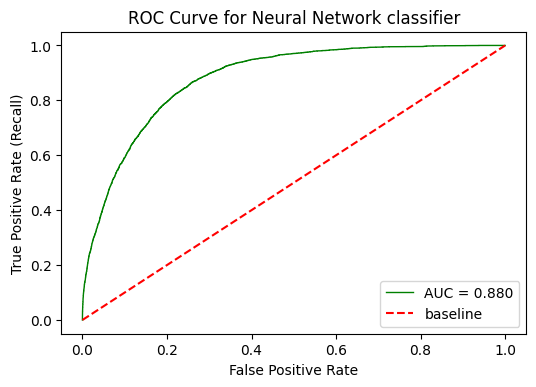

In [27]:
# get fpr and tpr
fpr, tpr, thresholds = roc_curve(y_test, nn.model.predict(x_test), pos_label=1)
# gets area under the curve (will be plotted in legend)
roc_auc = auc(fpr, tpr)
plot_roc_curve(fpr, tpr, roc_auc)

### Confusion Matrix

In [28]:
def plot_confusion_matrix(c_matrix, save=False):
    plt.figure(figsize=(10, 8))
    ax = sns.heatmap(c_matrix, annot=True, cmap='Blues', annot_kws={"fontsize":18}, fmt='.1f',
                    xticklabels=['<=50k', '>50k'], yticklabels=['<=50k', '>50k'])
    ax.set_xlabel("Predicted Label", fontsize=20)
    ax.set_ylabel("True Label", fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=16)
    for t in ax.texts: t.set_text(t.get_text() + "%")
    if save: plt.savefig('cm.png', bbox_inches='tight')
    plt.show()

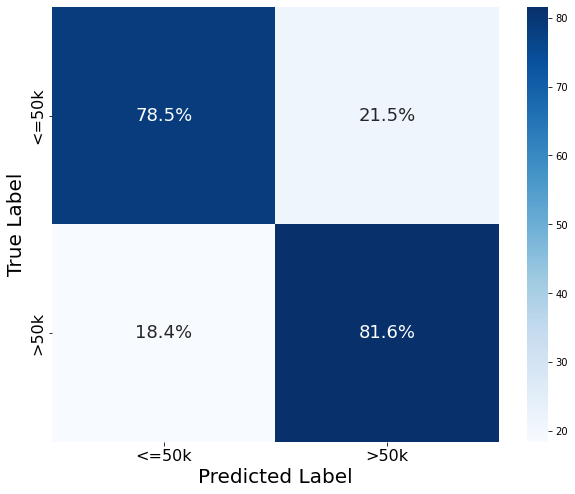

In [29]:
# TO DO: plot the actual label names (<50k, >50k)
y_test_pred = (nn.model.predict(x_test) > 0.5).astype("float")
cm = confusion_matrix(y_test, y_test_pred, normalize='true')*100
plot_confusion_matrix(cm)

In [ ]:
print(plt.hist(y_test_pred))